# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [ ]:
#!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 18kB/s 
     |████████████████████████████████| 450kB 39.8MB/s 
     |████████████████████████████████| 3.9MB 39.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=298e247cf4a041f94631386786295da9cfedc03d5c92cc6a3b3a2c16fc22fd03
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

Init Plugin
Init Graph Optimizer
Init Kernel
2.5.0
2.5.0


# Загружаем данные

In [11]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [12]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [13]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

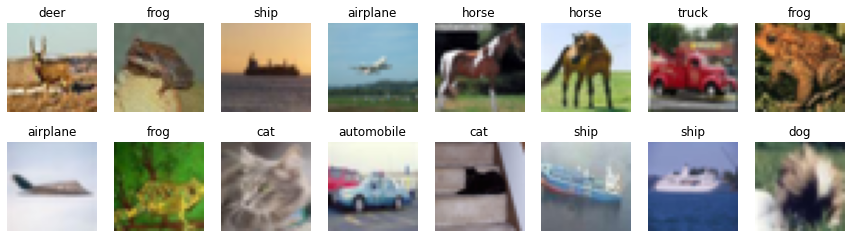

In [14]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [15]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [16]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [17]:
def make_default_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(.25))
    model.add(L.Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D(pool_size=(2, 2)))
    model.add(L.Flatten())
    model.add(Dropout(.25))
    model.add(Dense(256, activation='relu',)) # второй скрытый слой
    model.add(L.BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax',)) # выходной слой


    
    return model

In [22]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

# Тренируем модель

In [19]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

In [20]:
# учим дефолтную архитектуру
def_model = train_model()

2022-03-21 15:54:24.524815: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-21 15:54:24.525023: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-03-21 15:54:24.768109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.4566 - accuracy: 0.4974

2022-03-21 15:54:58.116434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 35s 19ms/step - loss: 1.4566 - accuracy: 0.4974 - val_loss: 1.1897 - val_accuracy: 0.6182
Epoch 2/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0213 - accuracy: 0.6452 - val_loss: 1.1115 - val_accuracy: 0.6436
Epoch 3/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.8084 - accuracy: 0.7199 - val_loss: 0.9912 - val_accuracy: 0.6685
Epoch 4/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.5647 - accuracy: 0.8077 - val_loss: 1.0817 - val_accuracy: 0.6705
Epoch 5/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.3523 - accuracy: 0.8820 - val_loss: 1.1793 - val_accuracy: 0.6678
Epoch 6/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.2178 - accuracy: 0.9270 - val_loss: 1.3231 - val_accuracy: 0.6716
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.1699 - accuracy: 0.9422 - val_loss: 1.4380 - val_accura

In [21]:
def_model.evaluate(x_test2, y_test2)

313/313 [==============================] - 2s 7ms/step - loss: 1.6296 - accuracy: 0.6816


[1.6295826435089111, 0.681600034236908]

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [7]:
def make_sigmoid_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(.25))
    model.add(L.Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=(3, 3) , strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D(pool_size=(2, 2)))
    model.add(L.Flatten())
    model.add(Dropout(.25))
    model.add(Dense(256, activation='sigmoid',)) # второй скрытый слой
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax',)) # выходной слой
    return model

In [8]:
def train_sigmoid_model(make_model_func=make_sigmoid_model, optimizer="sgd"):
    BATCH_SIZE = 32
    EPOCHS = 10

    K.clear_session()
    model = make_model_func()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    model.fit(
        x_train2, y_train2,  # нормализованные данные
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_test2, y_test2),
        shuffle=False
        )
  
    return model

In [9]:
sigm_model = train_sigmoid_model()

NameError: name 'K' is not defined

In [39]:
sigm_model.evaluate(x_test2, y_test2)

313/313 [==============================] - 2s 7ms/step - loss: 1.6335 - accuracy: 0.6356


[1.633487582206726, 0.6356000304222107]

In [34]:
sigm_model.history.history

{}

In [ ]:
def make_sigmoid_model():
    ...

In [ ]:
# учим sigmoid
train_model(make_sigmoid_model)

In [ ]:
# учим sgd
train_model(optimizer="sgd")

In [ ]:
def make_bn_model():
    ...

In [ ]:
# учим bn
train_model(make_bn_model)

In [ ]:
def make_sigmoid_bn_model():
    ...

In [ ]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)